In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression


In [204]:
#Read the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [205]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [206]:
#Determine if there are any columns with NaN values
missing_cols = df_train.columns[df_train.isna().any()].tolist()
print("The columns with the missing data are the following: " + str(missing_cols))

The columns with the missing data are the following: ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


In [207]:
# Almost all the columns have NaN values, so we need to determine the percentage of NaN values in each column
def count_nans(df):
    print("The percentage of NaN values in each column is the following: ")
    for col in df.columns:
        print(col, df[col].isna().sum()/len(df[col])*100)

count_nans(df_train)

The percentage of NaN values in each column is the following: 
PassengerId 0.0
HomePlanet 2.312205222592891
CryoSleep 2.4962613597147127
Cabin 2.289198205452663
Destination 2.093638559760727
Age 2.0591280340503855
VIP 2.3352122397331185
RoomService 2.082135051190613
FoodCourt 2.105142068330841
ShoppingMall 2.392729782583688
Spa 2.105142068330841
VRDeck 2.1626596111814105
Name 2.300701714022777
Transported 0.0


As we can see, almost all the columns have around 2% of missing values, which can be handled with imputation. 

In [208]:
# Let's convert the type of the column "Transported" to integer from the bool type
df_train["Transported"] = df_train["Transported"].astype(int)

As can be seen from the data, the Cabin column contatins the cabin number in the deck/num/side format. Therefore, we can separate the data about deck and side into separate categorical columns. 

In [209]:
# Configure the column Cabin. \d - any digit
def cabin_conf(input):
    input = str(input)
    cabin_conf_pattern = r"/\d+/"
    output = re.sub(cabin_conf_pattern, "/", input)

    return output

df_train["Cabin_conf"] = df_train["Cabin"].apply(cabin_conf)
df_test["Cabin_conf"] = df_test["Cabin"].apply(cabin_conf)

# Divide the data into two different columns 
df_train[['Cabin_Deck', 'Cabin_Side']] = df_train['Cabin_conf'].str.split('/', expand=True)
df_test[['Cabin_Deck', 'Cabin_Side']] = df_test['Cabin_conf'].str.split('/', expand=True)

df_train.drop(['Cabin_conf'], axis=1, inplace=True)
df_test.drop(['Cabin_conf'], axis=1, inplace=True)

df_train.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_Side
4618,4923_02,Mars,True,F/935/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,0.0,Yalmon Sturt,1,F,S
239,0257_01,Mars,False,F/49/S,55 Cancri e,21.0,False,1664.0,0.0,NaN,0.0,0.0,Errohs Berte,0,F,S
8024,8588_01,Mars,True,E/562/S,TRAPPIST-1e,59.0,False,0.0,0.0,0.0,0.0,0.0,Gramus Wist,1,E,S
7088,7549_01,Earth,False,E/489/P,TRAPPIST-1e,22.0,False,0.0,19.0,1468.0,2.0,119.0,Beula Beangley,1,E,P
7949,8489_01,Earth,True,G/1383/P,PSO J318.5-22,22.0,False,NaN,0.0,0.0,0.0,0.0,Elicey Danielps,1,G,P
6345,6711_01,Mars,False,D/210/P,TRAPPIST-1e,25.0,True,NaN,280.0,714.0,0.0,0.0,Igrish Perle,0,D,P
700,0733_01,Earth,False,F/153/P,55 Cancri e,23.0,False,0.0,38.0,88.0,4.0,561.0,Lulah Hamberterry,0,F,P
1761,1872_01,Mars,True,E/139/S,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Stote Wala,0,E,S
4414,4689_01,Europa,False,C/182/S,TRAPPIST-1e,28.0,True,0.0,3119.0,0.0,1404.0,366.0,Stra Persoffly,1,C,S
3940,4207_01,NaN,True,B/163/S,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Scepton Perable,1,B,S


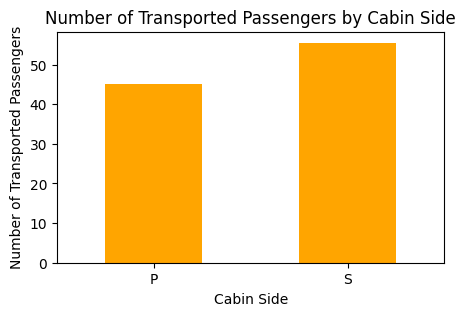

In [210]:
cabin_side_transported = df_train.groupby('Cabin_Side')['Transported'].sum()
cabin_side_total = df_train["Cabin_Side"].value_counts()
cabin_side_percentage = cabin_side_transported / cabin_side_total * 100

plt.figure(figsize=(5, 3))
cabin_side_percentage.plot(kind='bar', color='orange')
plt.title('Number of Transported Passengers by Cabin Side')
plt.xlabel('Cabin Side')
plt.ylabel('Number of Transported Passengers')
plt.xticks(rotation=0)
plt.show()

As can be observed from the plot, the distribution between those who were transported is almost equal and do not depend much on the cabin side.

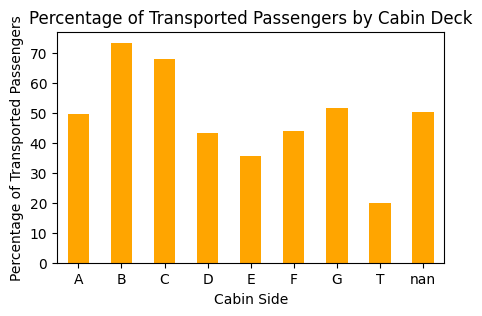

In [211]:
cabin_deck_transported = df_train.groupby('Cabin_Deck')['Transported'].sum()
cabin_deck_total = df_train["Cabin_Deck"].value_counts()
cabin_deck_percentage = cabin_deck_transported / cabin_deck_total * 100

plt.figure(figsize=(5, 3))
cabin_deck_percentage.plot(kind='bar', color='orange')
plt.title('Percentage of Transported Passengers by Cabin Deck')
plt.xlabel('Cabin Side')
plt.ylabel('Percentage of Transported Passengers')
plt.xticks(rotation=0)
plt.show()

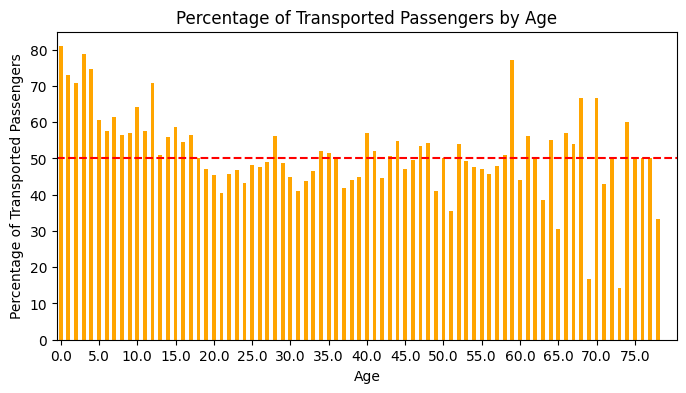

In [231]:
# Calculate the total count of passengers for each age
age_total = df_train["Age"].value_counts()

# Group the data by Age and calculate the sum of the Transported column
transported_passengers = df_train[df_train['Transported'] == 1]
age_transported_count = transported_passengers['Age'].value_counts()

unique_ages = df_train['Age'].unique()
age_transported = pd.Series(0, index=unique_ages)
age_transported.update(age_transported_count)

age_total.sort_index(inplace=True)
age_transported.sort_index(inplace=True)

# Calculate the percentage of transported passengers by age
age_transported_percentage = age_transported / age_total * 100

# Create a stacked bar plot
plt.figure(figsize=(8, 4))
age_transported_percentage.plot(kind='bar', color='orange')
plt.axhline(y=50, color='red', linestyle='--', label='Y=50')
plt.title('Percentage of Transported Passengers by Age')
plt.xlabel('Age')
plt.ylabel('Percentage of Transported Passengers')
plt.xticks(np.arange(min(unique_ages), max(unique_ages)+1, 5), rotation=0)
plt.show()

It can be clearly seen from the plot that the minor aged passengers are more likely to be transported than others. On this basis, we can add a new feature which will show if the passenger is minor, youth from 19 to 27 or adult. 

Now, let's determine which columns are categorical and should be encoded. 

In [232]:

nunique_cnt = df_train.nunique()
print(nunique_cnt)
low_card_cols = nunique_cnt[nunique_cnt < 20].index.tolist()
print("The following columns will be translated into categorical: " + str(low_card_cols))

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train[low_card_cols] = ordinal_encoder.fit_transform(df_train[low_card_cols])
df_test[low_card_cols] = ordinal_encoder.fit_transform(df_test[low_card_cols])

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
Cabin_Deck         9
Cabin_Side         3
dtype: int64
The following columns will be translated into categorical: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'Cabin_Deck', 'Cabin_Side']


KeyError: "['Transported'] not in index"

In [ ]:
# Use imputer for ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']] columns

cols_impute_frequent = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']

my_imputer = SimpleImputer(strategy='most_frequent')

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

X_train_imputed[cols_impute_frequent] = my_imputer.fit_transform(X_train_imputed[cols_impute_frequent])
X_test_imputed[cols_impute_frequent] = my_imputer.transform(X_test_imputed[cols_impute_frequent])

# X_train_imputed.columns = X_train.columns
# X_valid_imputed.columns = X_valid.columns
# X_test_imputed.columns = X_test.columns


X_train = X_train_imputed
X_test = X_test_imputed

count_nans(X_train)

print(X_train.sample(10))

HomePlanet 0.0
CryoSleep 0.0
Cabin 0.0
Destination 0.0
Age 0.0
VIP 0.0
RoomService 0.0
FoodCourt 0.0
ShoppingMall 0.0
Spa 0.0
VRDeck 0.0
Cabin_Deck 0.0
Cabin_Side 0.0
      HomePlanet  CryoSleep  Cabin  Destination   Age  VIP  RoomService  \
5954         1.0        0.0    5.0          2.0  28.0  0.0          0.0   
2597         0.0        0.0   12.0          2.0  46.0  0.0          0.0   
5447         0.0        1.0   12.0          2.0  41.0  0.0          0.0   
3114         0.0        0.0   13.0          2.0  32.0  0.0          0.0   
7172         0.0        0.0   11.0          2.0  18.0  0.0        711.0   
6159         0.0        0.0   11.0          2.0  21.0  0.0          0.0   
5972         2.0        1.0   10.0          2.0   9.0  0.0          0.0   
5329         0.0        1.0   12.0          1.0  33.0  0.0          0.0   
5560         1.0        0.0    2.0          0.0  24.0  0.0          0.0   
2021         0.0        0.0   11.0          2.0  18.0  0.0          0.0   

       

In [ ]:
# Use imputer for money columns

cols_impute_mean = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', "Age"]

my_imputer_mean = SimpleImputer(strategy='median')

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

X_train_imputed[cols_impute_mean] = my_imputer_mean.fit_transform(X_train_imputed[cols_impute_mean])
X_test_imputed[cols_impute_mean] = my_imputer_mean.transform(X_test_imputed[cols_impute_mean])

X_train = X_train_imputed
X_test = X_test_imputed

count_nans(X_train)

print(X_train.sample(10))

HomePlanet 0.0
CryoSleep 0.0
Cabin 0.0
Destination 0.0
Age 0.0
VIP 0.0
RoomService 0.0
FoodCourt 0.0
ShoppingMall 0.0
Spa 0.0
VRDeck 0.0
Cabin_Deck 0.0
Cabin_Side 0.0
      HomePlanet  CryoSleep  Cabin  Destination   Age  VIP  RoomService  \
3913         1.0        0.0    4.0          2.0   0.0  0.0          0.0   
2286         0.0        1.0   12.0          1.0  13.0  0.0          0.0   
7322         0.0        1.0   13.0          1.0  28.0  0.0          0.0   
7553         0.0        0.0   11.0          0.0  19.0  0.0        355.0   
2283         2.0        1.0    8.0          2.0  27.0  0.0          0.0   
7111         0.0        0.0   13.0          1.0  45.0  0.0          1.0   
7834         0.0        1.0   12.0          0.0  25.0  0.0          0.0   
3573         0.0        0.0   12.0          2.0  27.0  0.0          0.0   
738          1.0        0.0    9.0          0.0   7.0  0.0          0.0   
1983         0.0        1.0   12.0          2.0  23.0  0.0          0.0   

       

In order to evaluate the performance of the model, let's define the MAE function.

In [ ]:
def mae(X_train, X_valid, y_train, y_valid, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, predictions)
    
    return accuracy

In [ ]:
# Select the target
y = df_train.Transported
# Select the features
X = df_train.drop(['Transported', "PassengerId"], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

model_rfc = RandomForestClassifier(n_estimators=500)
print(mae(X_train, X_valid, y_train, y_valid, model_rfc))

model_rfc.fit(X_train, y_train)
predictions = model_rfc.predict(X_test)

predictions = predictions.astype(bool)

0.7928193054738081


In [ ]:
# Create the model
# model = XGBRegressor(n_estimators=800,
#                          learning_rate=0.05) 
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': predictions})
output.to_csv('submission.csv', index=False)

print(len(output.index))

4277
